# Long Short Term Memory (LSTM)

## Deep learning projet 

## Marie PHILIPPE & Claire SERRAZ - M2 D3S

# 1. Libraries

In [1]:
# We may need to run these two lines if we don't have these libraries
#!pip install tensorflow
#!pip install gensim

In [2]:
# We import some basic libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
# We import some libraries to clean the text
import nltk
from nltk.corpus import stopwords
from nltk import stem, WordNetLemmatizer
nltk.download('stopwords')
wnl = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /Users/marie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# We import some libraries needed for the measures
from sklearn.metrics import accuracy_score
from sklearn import model_selection

In [5]:
# We import some libraries from tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Bidirectional, LSTM, Input, Embedding
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

from gensim.models import FastText
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 2. Import and prepare the data

In [6]:
# We choose the path

# Path for Marie
os.chdir("/Users/marie/Desktop/Cours/S1/DL/Project/Data")

# Path for Claire
#os.chdir("C:/DESKTOP/Project Fake news")

In [7]:
# We import the dataset

data = pd.read_csv('data.csv')
data = data.astype({"text": str, 'title':str})
data

,title,text,subject,date,class
0,donald trump sends embarrassing new year eve m...,donald trump wish american happy new year leav...,News,"December 31, 2017",fake
1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,News,"December 31, 2017",fake
2,sheriff david clarke becomes internet joke thr...,friday revealed former milwaukee sheriff david...,News,"December 30, 2017",fake
3,trump obsessed even obama name coded website i...,christmas day donald trump announced would bac...,News,"December 29, 2017",fake
4,pope francis called donald trump christmas speech,pope francis used annual christmas day message...,News,"December 25, 2017",fake
...,...,...,...,...,...
44893,fully committed nato back new u approach afgha...,brussels reuters nato ally tuesday welcomed pr...,worldnews,"August 22, 2017",true
44894,lexisnexis withdrew two product chinese market,london reuters lexisnexis provider legal regul...,worldnews,"August 22, 2017",true
44895,minsk cultural hub becomes authority,minsk reuters shadow disused soviet-era factor...,worldnews,"August 22, 2017",true
44896,vatican upbeat possibility pope francis visiti...,moscow reuters vatican secretary state cardina...,worldnews,"August 22, 2017",true


# 3. LSTM Models

###  Functions

In [9]:
# We define a function to display loss and accuracy evolution during training
def plot_history(hist):
  plt.plot(hist.history['loss'], label='train')
  plt.plot(hist.history['val_loss'], label='val')
  plt.legend()
  plt.ylim((0,1))
  plt.title('Loss evolution')
  plt.show()
  plt.plot(hist.history['binary_accuracy'], label='train')
  plt.plot(hist.history['val_binary_accuracy'], label='val')
  plt.legend()
  plt.ylim((0,1))
  plt.title('Accuracy evolution')
  plt.show()

In [10]:
# We define function to evaluate model performances
def model_evaluation(NN_model, x_test, y_test): 
  y_pred_proba = NN_model.predict(x_test, verbose=1)
  y_pred = [1 if i >= 0.5 else 0 for i in y_pred_proba]
  print('accuracy {}'.format(round(accuracy_score(y_test, y_pred), 4)))

### LSTM without pre-trained embedding

In [11]:
# We define our train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    data['text'], 
    data['class'], 
    test_size=0.20, 
    random_state=42)

In [12]:
# We define some input parameters

# VOCAB_SIZE is the maximum number of words take into account by the model 
VOCAB_SIZE = 10000
# MAX_LENGTH is the maximum number of words per text review
MAX_LENGTH = 100
# EMBEDDING_DIM is the dimension of the embedding layer in the network
EMBEDDING_DIM = 200
# MODEL_OUTPUT_DIM is the number of class - 1
MODEL_OUPUT_DIM = 1

In [13]:
# Tokenizer transforms sequences of word into sequences of index
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,.:;<=>?@[\\]^_`{|}~\t\n')

# We fit it on the X train set
tokenizer.fit_on_texts(X_train)

# We then vectorize the X train set
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post', truncating='post')

# We then vectorize the X test set
X_test = tokenizer.texts_to_sequences(X_test) 
X_test = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post', truncating='post')

# We set out-of index vocabulary to 0
X_train[X_train >= VOCAB_SIZE] = 0
X_test[X_test >= VOCAB_SIZE] = 0 

In [14]:
# We create a function that take as input the number of class, the size of the vocabulary, 
# the maximum length and the embedding dimension, and from that create a lstm model

# The Embedding layer is initialized with random weights 
# and will learn an embedding for all of the words in the training dataset.

def build_lstm_model(nb_class, voc_size, max_length, embedding_dim):

    inp = Input(shape=(max_length, ))

    x = Embedding(input_dim=voc_size,
                  output_dim=embedding_dim,
                  input_length=max_length,
                  trainable=True)(inp)

    x = Bidirectional(LSTM(128))(x)
    out = Dense(nb_class, activation='sigmoid', name='output')(x)

    model = Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(lr=0.005)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])

    return model

In [15]:
# We apply it with the parameters we fixed earlier

lstm_model = build_lstm_model(
    MODEL_OUPUT_DIM, 
    VOCAB_SIZE,
    MAX_LENGTH,
    EMBEDDING_DIM)

/Users/marie/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
history = lstm_model.fit(
    X_train,
    y_train.values,
    epochs=2,
    batch_size=1024,
    verbose=1,
    validation_split=0.1
    )

Epoch 1/2
32/32 [==============================] - 169s 5s/step - loss: 0.1948 - binary_accuracy: 0.9233 - val_loss: 0.0286 - val_binary_accuracy: 0.9897
Epoch 2/2
32/32 [==============================] - 153s 5s/step - loss: 0.0089 - binary_accuracy: 0.9977 - val_loss: 0.0094 - val_binary_accuracy: 0.9969


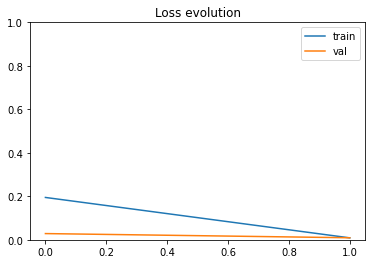

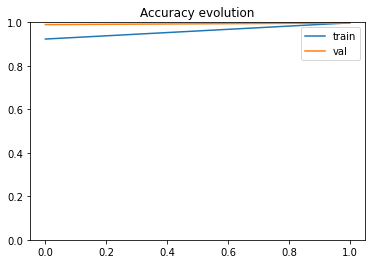

281/281 [==============================] - 19s 66ms/step
accuracy 0.998


In [17]:
plot_history(history)
model_evaluation(NN_model=lstm_model, x_test=X_test, y_test=y_test)